## Load players from the other branches

In [1]:
from players import *

# Part4: rMPIPD with mutating strategies
(*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined. 

In [2]:
# %load_ext lab_black
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy 
import time
from IPython import display

try:
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    print("graphviz_layout not installed")

In [3]:
# redefine KBadGuy class adding ID and family
class KBadGuy2(KBadGuy):
    def __init__(self, k=None, family=[], r_history=[], move_history=[], ID=None):
        KBadGuy.__init__(self, k=k, r_history=[], move_history=[])
        self.ID = ID
        self.family = family

In [4]:
# this function assume the standard payoff 0 1 2 3
def calc_reward(Nc, c):
    if c == 0:  # not collaborating
        return 2 * (Nc) + 1

    else:
        return 2 * (Nc - 1)


def MPIPD(P_list, GI):
    """
    Multiplayer game loop function
    """
    for i in range(GI):

        # matrix with all the players move of this round
        U = np.array([P_list[i].move() for i in range(len(P_list))]).T

        # number of collaborating players
        Nc = np.sum(U[0, :])

        for k in range(len(P_list)):  # for each player

            # Calculate rewards
            P_list[k].append_reward(calc_reward(Nc, U[0, k]))

            # check if player is tit4tat, if yes, update input history
            if isinstance(P_list[k], Tit4Tat):

                if Nc > np.ceil(len(P)) / 2:  # at lest 50% are collaborating
                    P_list[k].append_input([1, 0])

                else:  # less than 50% are collaborating
                    P_list[k].append_input([0, 1])

            if isinstance(P_list[k], Tit4TatMP) or isinstance(P_list[k], GrimTriggerMP):
                P_list[k].append_input(np.delete(U, k, axis=1).T)


class IDSupplier:
    """
    class that assign an return incremental unique ID
    """

    def __init__(self):
        self.count = 0

    def new_id(self):
        id = self.count
        self.count += 1
        return id


# P_list = player list
def evolvingMPIPD(
    P_list,
    num_epochs,
    GI,
    max_population,
    children=1,
    delta_range=10,
    display_graph=False,
):
    """
    parameters:
        P_list (list): initial players instances.
        num_epochs (int): number of epochs performed.
        GI (int): game iterations inside a epoch.
        max_population (int): maximum number of players that can be active
            during an epoch.
    Return:
        it modifies the input P_list
        G: directed graph networkx
    """
    G = nx.DiGraph()

    all_k_history = []
    
    id_sup = IDSupplier()
    for i, player in enumerate(P_list):
        player.ID = id_sup.new_id()
        G.add_node(player.ID, color="skyblue")

    if display_graph:
        fig, ax = plt.subplots(figsize=(24, 11))

    for epoch in range(num_epochs):
        
        all_k = []
        
        # reset the reward history
        for player in P_list:
            player.p_reset()

        # call a game loop
        MPIPD(P_list, GI)

        def key_r(player):
            return sum(player.r_history)

        # sort the player list inplace
        P_list.sort(reverse=True, key=key_r)

        # kill the player with small rewards and keep population stable
        while len(P_list) > max_population:
            dead_player = P_list.pop()
            colors = nx.get_node_attributes(G, "color")
            colors[dead_player.ID] = "salmon"
            nx.set_node_attributes(G, colors, "color")

        # remaining players make new children
        current_P = len(P_list)
        
        for player in P_list[0:current_P]:
            for i in range(children):
                son = KBadGuy2(
                    np.clip(
                        player.k + np.random.uniform(-delta_range, delta_range), 0, 100
                    ),
                    [],
                    [],
                    [],
                    id_sup.new_id(),
                )
                # add parent ID to the son family
                player.family.append(son.ID)
                
                G.add_node(son.ID, color="skyblue")
                G.add_edge(player.ID, son.ID)
                P_list.append(son)

        if display_graph:
            plt.title("Tree")
            pos = graphviz_layout(G, prog="dot")
            nx.draw(
                G,
                pos,
                node_color=nx.get_node_attributes(G, "color").values(),
                with_labels=False,
                arrows=True,
            )
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.savefig(f"epoch_{epoch}.png")
        
        for player in P_list:
            all_k.append(player.k)
            
        all_k_history.append(all_k)
        
    if display_graph:
        plt.clf()
    return G, all_k_history

In [5]:
P_list = [
    KBadGuy2(10, [], [], []),
    KBadGuy2(20, [], [], []),
    KBadGuy2(30, [], [], []),
    KBadGuy2(25, [], [], []),
    KBadGuy2(60, [], [], []),
]

G, all_k_history = evolvingMPIPD(P_list, 50, 30, 40, children=2, display_graph=False)

In [6]:
# for player in P_list:
#     print(len(player.family))
#     break

In [7]:
# if "graphviz_layout" in dir(nx.drawing.nx_agraph):
#     fig, ax = plt.subplots(figsize=(24, 11))
#     plt.title("Tree")
#     pos = graphviz_layout(G, prog="dot")
#     nx.draw(
#         G,
#         pos,
#         node_color=nx.get_node_attributes(G, "color").values(),
#         with_labels=False,
#         arrows=True,
#     )

In [8]:
# OBSOLETO
# colors = nx.get_node_attributes(G, "color")

# for key, value in colors.items():
#     if value == "salmon":
#         colors[key] = "white"

# nx.set_node_attributes(G, colors, "color")

In [9]:
# fig, ax = plt.subplots(figsize=(10, 10))
# nx.draw(
#     G,
#     node_color=nx.get_node_attributes(G, "color").values(),
#     with_labels=False,
#     arrows=True,
# )

In [10]:
# nodes_list = list(G.nodes(data="color"))
# for i, color in nodes_list:
#     if color == "salmon":
#         G.remove_node(i)

# fig, ax = plt.subplots(figsize=(10, 10))
# nx.draw(
#     G,
#     node_color=nx.get_node_attributes(G, "color").values(),
#     with_labels=False,
#     arrows=True,
# )

In [11]:
# if "graphviz_layout" in dir(nx.drawing.nx_agraph):
#     fig, ax = plt.subplots(figsize=(24, 6))
#     pos = graphviz_layout(G, prog="dot")
#     nx.draw(
#         G,
#         pos,
#         node_color=nx.get_node_attributes(G, "color").values(),
#         with_labels=False,
#         arrows=True,
#     )

In [81]:
%matplotlib agg
import matplotlib as cm
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)
for i, k_frame in enumerate(all_k_history):
    plt.scatter(range(len(k_frame)), k_frame, color="#1f77b4")
    camera.snap()

anim = camera.animate()
HTML(anim.to_html5_video())

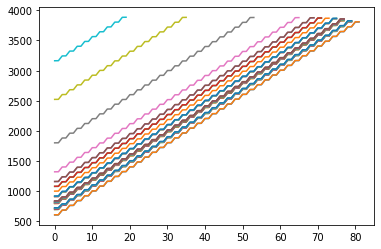

In [82]:
%matplotlib inline

for player in P_list:
    plt.plot(player.family)
plt.show()

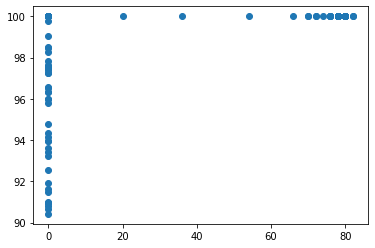

In [83]:
k_list = []
family_len_list = []

for player in P_list:
    k_list.append(player.k)
    family_len_list.append(len(player.family))

family_len_ar = np.array(family_len_list)
k_list_ar = np.array(k_list)
ids = np.argsort(family_len_list)

plt.scatter(family_len_ar[ids], k_list_ar[ids])
plt.show()

### Try with different players

In [ ]:
class Tit4TatMP2(Tit4TatMP):
    """
    Player that starts with cooperate and then cooperates only if a fraction of players
    above or equal c_treshold has cooperated.
    """

    def __init__(
        self,
        family=[],
        r_history=[],
        move_history=[],
        input_history=[],
        c_threshold=0.5,
        ID=None,
    ):
        Tit4TatMP.__init__(self, r_history=[], move_history=[], input_history=[], c_threshold=0.5)
        self.ID = ID
        self.family = family



class GrimTriggerMP2(GrimTriggerMP):
    """
    Player that cooperates until a numbers of players >= d_threshold defect in a turn,
    from now on he defects in every turn.
    Setting d_threshold=0 means that it needs only one defecting player
    to start defecting itself.
    """

    def __init__(
        self,
        family=[],
        r_history=[],
        move_history=[],
        input_history=[],
        d_threshold=0.5,
        ID=None,
    ):
        GrimTriggerMP.__init__(self, r_history=[], move_history=[], input_history=[], d_threshold=0.5)
        self.ID = ID
        self.family = family


class LookBackPlayer2(LookBackPlayer):
    """
    Player that use past rewards in order to decide the next move.
    """

    def __init__(
        self, bias=None, family=[], r_history=[], move_history=[], memory=np.inf, ID=None
    ):
        LookBackPlayer.__init__(self, bias, r_history=[], move_history=[])
        self.ID = ID
        self.family = family

In [ ]:
# P_list = player list
def evolvingMPIPD2(
    P_list,
    num_epochs,
    GI,
    max_population,
    children=1,
    delta_range=10,
    display_graph=False,
):
    """
    parameters:
        P_list (list): initial players instances.
        num_epochs (int): number of epochs performed.
        GI (int): game iterations inside a epoch.
        max_population (int): maximum number of players that can be active
            during an epoch.
    Return:
        it modifies the input P_list
        G: directed graph networkx
    """
    G = nx.DiGraph()

    id_sup = IDSupplier()
    for i, player in enumerate(P_list):
        player.ID = id_sup.new_id()
        G.add_node(player.ID, color="skyblue", player_type=type(player).__name__)

    if display_graph:
        fig, ax = plt.subplots(figsize=(24, 11))

    for epoch in range(num_epochs):
        # reset the reward history
        for player in P_list:
            player.p_reset()

        # call a game loop
        MPIPD(P_list, GI)

        def key_r(player):
            return sum(player.r_history)

        # sort the player list inplace
        P_list.sort(reverse=True, key=key_r)

        # kill the player with small rewards and keep population stable
        while len(P_list) > max_population:
            dead_player = P_list.pop()
            colors = nx.get_node_attributes(G, "color")
            colors[dead_player.ID] = "salmon"
            nx.set_node_attributes(G, colors, "color")

        # remaining players make new children
        current_P = len(P_list)

        for player in P_list[0:current_P]:

            player_type = type(player).__name__
            for i in range(children):

                if player_type == "KBadGuy2":
                    son = KBadGuy2(
                        player.k,
                        player.family + [player.ID],
                        [],
                        [],
                        ID=id_sup.new_id(),
                    )
                elif player_type == "Tit4TatMP2":
                    son = Tit4TatMP2(
                        player.family,
                        [],
                        [],
                        [],
                        c_threshold=player.c_threshold,
                        ID=id_sup.new_id(),
                    )

                elif player_type == "GrimTriggerMP2":
                    son = GrimTriggerMP2(
                        player.family,
                        [],
                        [],
                        [],
                        d_threshold=player.d_threshold,
                        ID=id_sup.new_id(),
                    )
                elif player_type == "LookBackPlayer2":
                    son = LookBackPlayer2(
                        bias=player.bias,
                        family=player.family,
                        r_history=[],
                        move_history=[],
                        ID=id_sup.new_id(),
                    )

                # add parent ID to the son family
                son.family.append(player.ID)
                
                G.add_node(son.ID, color="skyblue", player_type=player_type)
                G.add_edge(player.ID, son.ID)
                P_list.append(son)

        if display_graph:
            plt.title("Tree")
            pos = graphviz_layout(G, prog="dot")
            nx.draw(
                G,
                pos,
                node_color=nx.get_node_attributes(G, "color").values(),
                with_labels=True,
                labels=nx.get_node_attributes(G, "player_type"),
                arrows=True,
            )
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.savefig(f"epoch_{epoch}.png")
    if display_graph:
        plt.clf()
    return G

In [ ]:
P_list = [
    KBadGuy2(10, [], [], []),
    Tit4TatMP2([], [], [], [], c_threshold=0.5),
    GrimTriggerMP2([], [], [], [], 0),
    LookBackPlayer2(0, [], [], []),
]

G = evolvingMPIPD2(P_list, 5, 30, 40, children=2, display_graph=False)

In [ ]:
# if "graphviz_layout" in dir(nx.drawing.nx_agraph):
#     fig, ax = plt.subplots(figsize=(24, 11))
#     plt.title("Tree")
#     pos = graphviz_layout(G, prog="dot")
#     nx.draw(
#         G,
#         pos,
#         node_color=nx.get_node_attributes(G, "color").values(),
#         with_labels=True,
#         labels=nx.get_node_attributes(G, "player_type"),
#         arrows=True,
#     )

In [ ]:
# nodes_list = list(G.nodes(data="color"))
# for i, color in nodes_list:
#     if color == "salmon":
#         G.remove_node(i)

# fig, ax = plt.subplots(figsize=(10, 10))
# nx.draw(
#     G,
#     node_color=nx.get_node_attributes(G, "color").values(),
#     with_labels=True,
#     labels=nx.get_node_attributes(G, "player_type"),
#     arrows=True,
# )

In [ ]:
# if "graphviz_layout" in dir(nx.drawing.nx_agraph):

#     fig, ax = plt.subplots(figsize=(24, 6))
#     pos = graphviz_layout(G, prog="dot")
#     nx.draw(
#         G,
#         pos,
#         node_color=nx.get_node_attributes(G, "color").values(),
#         with_labels=True,
#         labels=nx.get_node_attributes(G, "player_type"),
#         arrows=True,
#     )

In [ ]:
for player in P_list:
    plt.plot(player.family)
plt.show()